# Partícula libre en PBC

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
x_serie = np.linspace(-4.0, 4.0, 200)

In [7]:
def lj(x, sigma):
    return (sigma/(x))**12


In [8]:
def lj_2(x, sigma):
    if x < 0:
        return (sigma/(x+4.0))**12
    else:
        return (sigma/(x-4.0))**12

In [9]:
v_serie = []
for x in x_serie:
    v_serie.append(lj(x, 2.0))

v_serie_2 = []
for x in x_serie:
    v_serie_2.append(lj_2(x, 2.0))

/tmp/ipykernel_696713/968276805.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  return (sigma/(x+4.0))**12
/tmp/ipykernel_696713/968276805.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  return (sigma/(x-4.0))**12


(-0.5, 2.0)

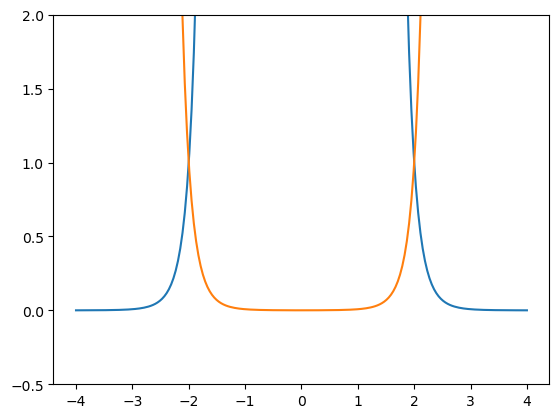

In [10]:
plt.plot(x_serie, v_serie)
plt.plot(x_serie, v_serie_2)
plt.ylim([-0.5, 2.0])

In [ ]:
import openmm as mm
from openmm import unit
from openmm import app
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from tqdm import tqdm

## Creamos el sistema

In [ ]:
system = mm.System()
system.addParticle(39.948 * unit.amu) # masa del átomo de argón

## Creamos el potencial externo

In [ ]:
force = mm.CustomExternalForce('(A / periodicdistance(0, 0, z, 0, 0, z0))^B')
force.addGlobalParameter('A',  2.0 * unit.nanometers)
force.addGlobalParameter('B',  12)
force.addGlobalParameter('z0',  0.0 * unit.nanometers)
force.addParticle(0)
system.addForce(force)

In [ ]:
if False:
    platform = mm.Platform.getPlatformByName('CPU')
    friction   = 5.0/unit.picoseconds
    integrator = mm.LangevinIntegrator(0.0*unit.kelvin, friction, 2.0*unit.femtoseconds)
    context = mm.Context(system, integrator, platform)
    L = 8.0
    v1 = [L,0,0] * unit.nanometers
    v2 = [0,L,0] * unit.nanometers
    v3 = [0,0,L] * unit.nanometers
    L = L * unit.nanometers
    context.setPeriodicBoxVectors(v1, v2, v3)

    serie_z = np.linspace(-4.0,4.0,200)
    serie_E =[]

    for z in serie_z:
        context.setPositions([[0.0, 0.0, z]] * unit.nanometers)
        E = context.getState(getEnergy=True).getPotentialEnergy()._value
        serie_E.append(E)

    plt.plot(serie_z, serie_E)
    plt.ylim([-0.5,100])

## Estado termodinámico

In [ ]:
# Formalismo NVT
temperature = 300*unit.kelvin
pressure    = None

## Parametros de la simulación

In [ ]:
integration_timestep = 2.0*unit.femtoseconds
saving_timestep = 1.00*unit.picoseconds
simulation_time = 2500.*unit.picoseconds

saving_steps = int(saving_timestep/integration_timestep)
num_saving_steps = int(simulation_time/saving_timestep)

## Integrador

In [ ]:
friction   = 5.0/unit.picoseconds
integrator = mm.LangevinIntegrator(temperature, friction, integration_timestep)

## Plataforma

In [ ]:
platform = mm.Platform.getPlatformByName('CPU')

## Reporteros

In [ ]:
times = np.zeros(num_saving_steps, np.float32) * unit.picoseconds
positions  = np.zeros([num_saving_steps,3], np.float32) * unit.angstroms
velocities = np.zeros([num_saving_steps,3], np.float32) * unit.angstroms/unit.picosecond
potential_energies   = np.zeros([num_saving_steps], np.float32) * unit.kilocalories_per_mole
kinetic_energies     = np.zeros([num_saving_steps], np.float32) * unit.kilocalories_per_mole

## Condiciones iniciales

In [ ]:
initial_positions  = [[0.0, 0.0, 4.0]] * unit.nanometers

## Creamos el contexto

In [ ]:
context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)

In [ ]:
L = 8.0
v1 = [L,0,0] * unit.nanometers
v2 = [0,L,0] * unit.nanometers
v3 = [0,0,L] * unit.nanometers
L = L * unit.nanometers
context.setPeriodicBoxVectors(v1, v2, v3)

## Llenamos los reporteros para el paso 0

In [ ]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)

In [ ]:
times[0] =  state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

## Corriendo la simulación

In [ ]:
for ii in tqdm(range(1,num_saving_steps)):
    context.getIntegrator().step(saving_steps)
    state_xx = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state_xx.getTime()
    positions[ii] = state_xx.getPositions()[0]
    velocities[ii] = state_xx.getVelocities()[0]
    kinetic_energies[ii]=state_xx.getKineticEnergy()
    potential_energies[ii]=state_xx.getPotentialEnergy()

## Representamos los datos de la simulación

### Trayectoria

In [ ]:
plt.plot(positions[:,0], label='X')
plt.plot(positions[:,1], label='Y')
plt.plot(positions[:,2], label='Z')
plt.legend()
plt.show()